# Flight Price Prediction - EasyMyTrip

- The goal of this study is train linear regression, multivariable regression and polynomial regression techniques and tune the hyperparamters using GridSearch. 

- The metric that we will use at this study it's gonna be de MSE (mean squared error) and RMSE (root mean squared error).

In [615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

import operator

## Loading the data

In [616]:
df = pd.read_csv('Clean_Dataset.csv')

In [617]:
df.head(10)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
5,5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955
6,6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
7,7,Vistara,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060
8,8,GO_FIRST,G8-334,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954
9,9,GO_FIRST,G8-336,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954


In [618]:
# Dropping useless columns from dataframe
def clean(dataframe, columns):
    return dataframe.drop(columns, axis=1)

df = clean(df, ['Unnamed: 0', 'flight'])

In [619]:
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [620]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   source_city       300153 non-null  object 
 2   departure_time    300153 non-null  object 
 3   stops             300153 non-null  object 
 4   arrival_time      300153 non-null  object 
 5   destination_city  300153 non-null  object 
 6   class             300153 non-null  object 
 7   duration          300153 non-null  float64
 8   days_left         300153 non-null  int64  
 9   price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 22.9+ MB


- Categorical features (7): ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

- Numerical features (3): ['duration', 'days_left', 'price']

In [621]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


- Standard deviation from all columns is too high, even more at the price column.

- The dataframe has a lot of outliers (like a 49 hours flight and a flight price of $123071).


## Exploratory Data Analysis

### Numerical variables distribuition (duration, days_left, price)

array([[<AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'days_left'}>],
       [<AxesSubplot:title={'center':'price'}>]], dtype=object)

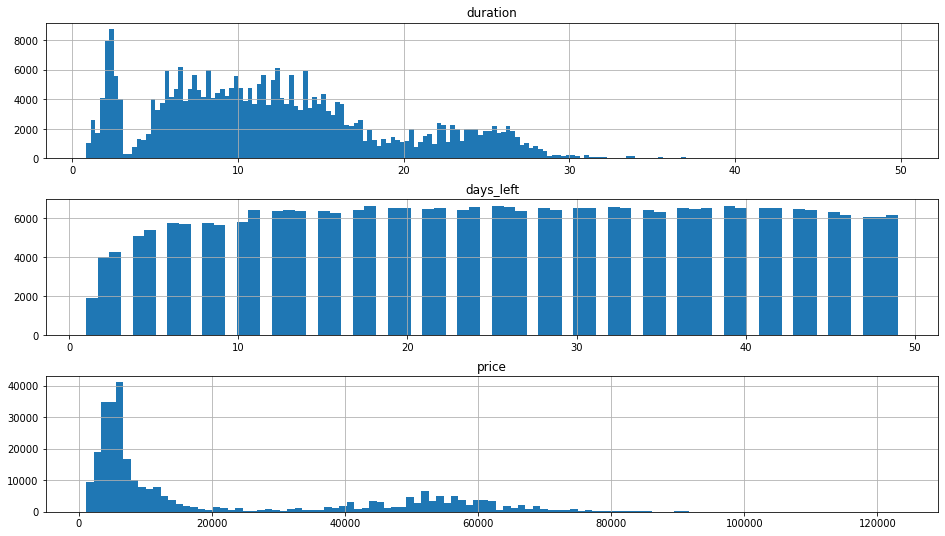

In [622]:
df.hist(bins='auto', figsize=(16,9), layout=(3,1))

### Categorical variables distribuition (airline, source_city, departure_time, stops, arrival_time, destination_city, class)

In [623]:
# Categorical variables dataframe
df_cat = df.iloc[:,0:7]
df_cat.describe()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class
count,300153,300153,300153,300153,300153,300153,300153
unique,6,6,6,3,6,6,2
top,Vistara,Delhi,Morning,one,Night,Mumbai,Economy
freq,127859,61343,71146,250863,91538,59097,206666


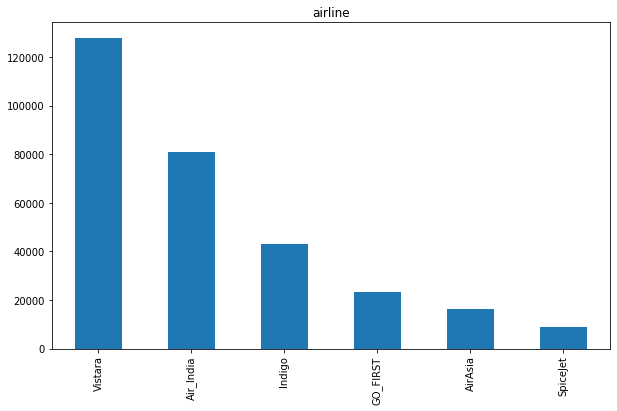

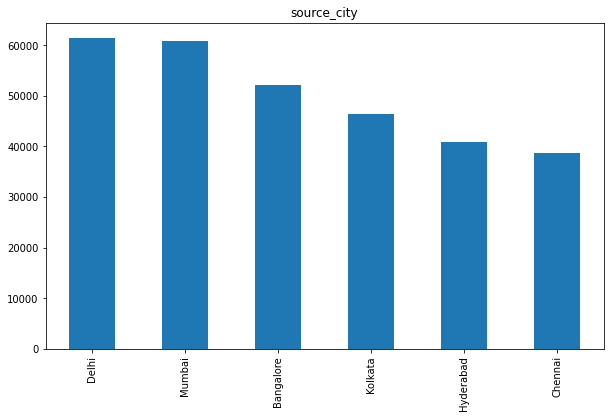

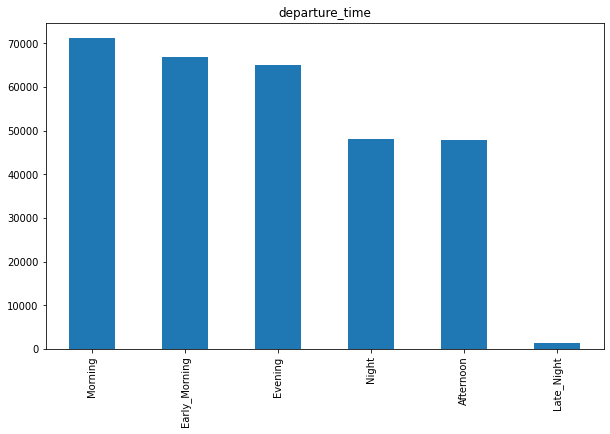

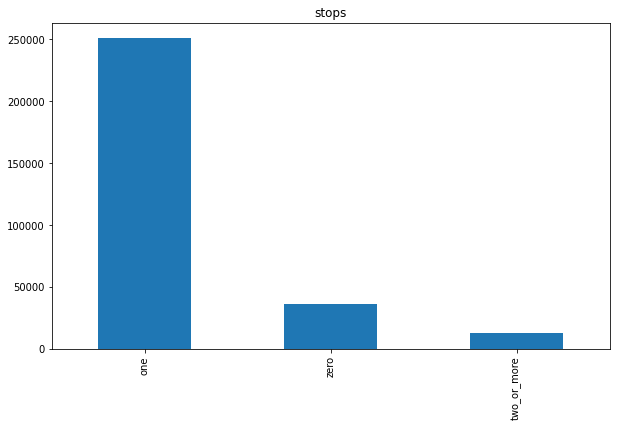

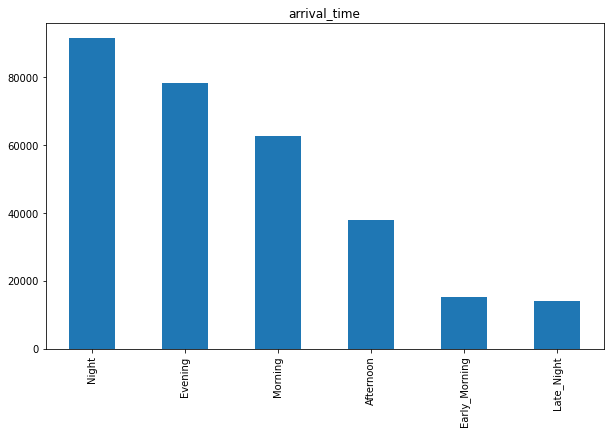

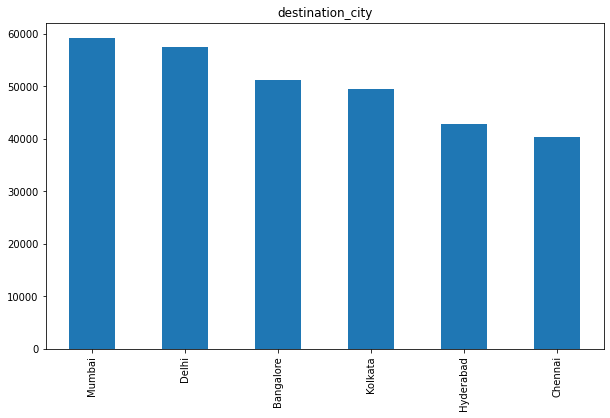

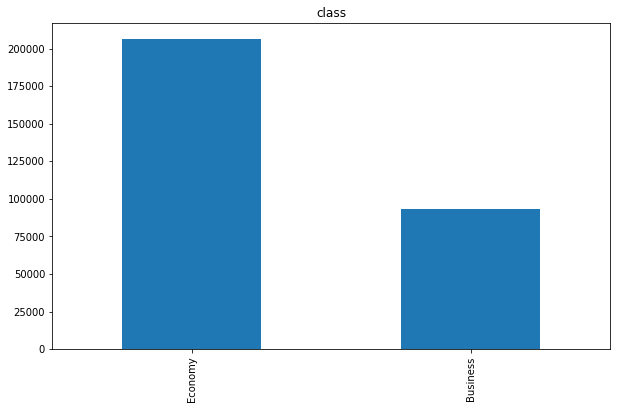

In [624]:
for i in df_cat:
    df_cat[i].value_counts().plot(kind='bar', figsize=(10,6))
    plt.title(i)
    plt.show()

### Dealing with duplicated data

In [625]:
# Dataframe with duplicated data
df[df.duplicated()]

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
10,GO_FIRST,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954
155,Vistara,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,2,7530
401,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,4,5953
403,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.33,4,5953
405,Vistara,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,4,5955
...,...,...,...,...,...,...,...,...,...,...
254827,Vistara,Bangalore,Evening,one,Morning,Kolkata,Business,14.75,32,60508
254890,Vistara,Bangalore,Evening,one,Morning,Kolkata,Business,14.75,33,60508
255218,Vistara,Bangalore,Evening,one,Morning,Kolkata,Business,14.75,38,60508
255291,Vistara,Bangalore,Evening,one,Morning,Kolkata,Business,14.75,39,60508


In [626]:
# Dropping duplicated data
df.drop_duplicates(keep='first', inplace=True)

### Dealing with missing data

In [627]:
df.isna().mean() 

airline             0.0
source_city         0.0
departure_time      0.0
stops               0.0
arrival_time        0.0
destination_city    0.0
class               0.0
duration            0.0
days_left           0.0
price               0.0
dtype: float64

- The dataframe does not have any missing data.

#### Notes:
- Duplicated data portion is tiny compared to the rest of the dataframe.

- We can observe that the company who appears the most at flights it's Vistara and AirIndia, respectively, which is a indicative from the portion of the market share that they represent.

- Flights with 2 stops or more are much more numerous than flights without stops.

- Flights from economic class are double than flights from business class.

## Splitting the dataframe into training, validation and test

In [628]:
price_cat = pd.qcut(df['price'], q=10)

# Splitting the dataframes that we gonna use to train, validate and test
df_train, df_test = train_test_split(df, test_size=0.2, stratify=price_cat, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)
del df

In [629]:
#Separando os dados de treinamento, validação e teste
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:,-1]

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:,-1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:,-1]

In [630]:
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_val:{X_val.shape}, y_val:{y_val.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}')

X_train:(178764, 9), y_train:(178764,)
X_val:(59588, 9), y_val:(59588,)
X_test:(59588, 9), y_test:(59588,)


## Training data - exploratory analysis

In [631]:
corr = df_train.corr()
corr['price'].sort_values(ascending=False).abs()

price        1.000000
duration     0.201852
days_left    0.092129
Name: price, dtype: float64

<AxesSubplot:>

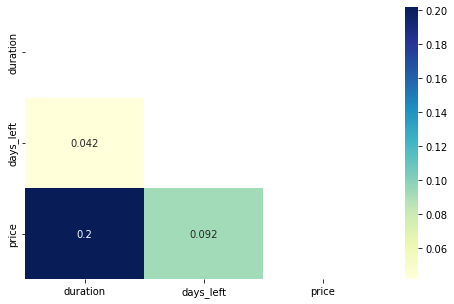

In [632]:
plt.figure(figsize=(8,5))
sns.heatmap(corr.abs(), annot=corr.abs(), mask=np.triu(np.ones_like(corr)), cmap='YlGnBu')

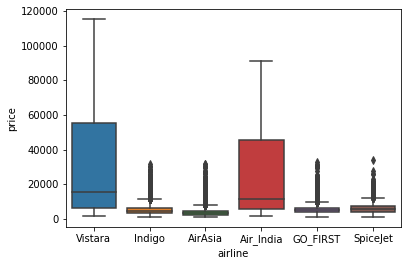

<Figure size 1080x720 with 0 Axes>

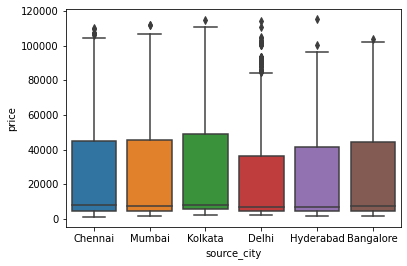

<Figure size 1080x720 with 0 Axes>

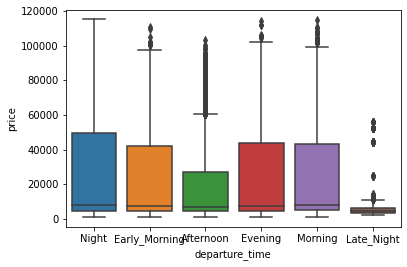

<Figure size 1080x720 with 0 Axes>

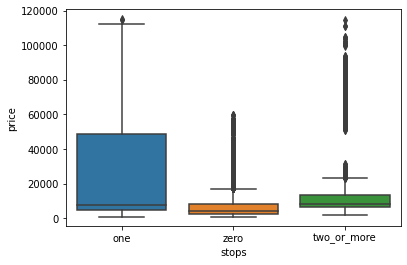

<Figure size 1080x720 with 0 Axes>

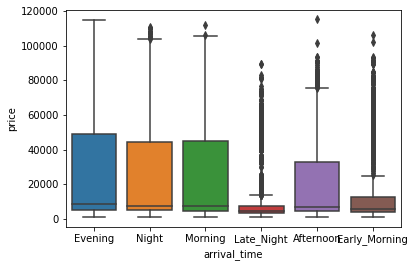

<Figure size 1080x720 with 0 Axes>

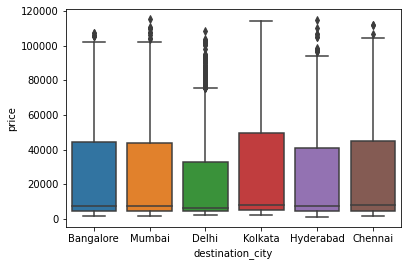

<Figure size 1080x720 with 0 Axes>

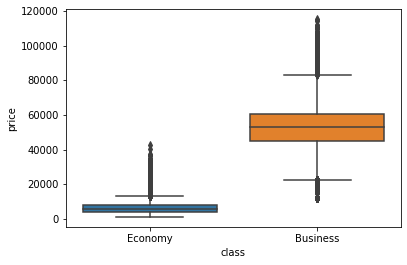

<Figure size 1080x720 with 0 Axes>

In [633]:
for i in df_train.iloc[:,0:7]:
    sns.boxplot(x=i, y="price", data=df_train)
    # sns.boxplot(x=i, y="price", data=df_train).set(yscale="log")
    plt.figure(figsize=(15,10))
    plt.show()


#### Notes:

- **Airline**: Vistara and Air India have the highest prices among all airlines (highest medians and a largest distribuiton at the third quartile).

- **Source_city**: this choice has a really small influence at the flight price, since all of them have the same distribuition.
    
- **Departure_time** : morning and night flights have higher prices. However, in the evening we get a big drop in these prices.

- **Stops**: flights with two stops or more have higher prices than flights without stops.

- **Arrival_time**: likewise the departure time, morning and night flights have higher prices.

- **Destination_city**: likewise the source city, this feature have a really small influence at the flight price.

- **Class**: we can observe that flights from business class are about 10x more expensive than the flights from economy class. Therefore, we can judge that the class is probably the feature most correlated with the price.

## Training the models

In [634]:
root_mean_squared_error = lambda a, b: np.sqrt(np.mean((a-b)**2))

In [635]:
# Numerical features
num_features = ['duration', 'days_left']

# Categorical features
cat_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class'] 

### Prediction just using the numerical features and without standarization

In [636]:
preprocess_a = make_column_transformer(
    ('passthrough', num_features),
    ('drop', cat_features))

# Pipeline
model_a = make_pipeline(
    preprocess_a,
    LinearRegression())
model_a.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_a.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_a.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_a.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_a.predict(X_val)):.2%}')

Train RMSE: 22162.41
Train MAPE: 211.95%
  Val RMSE: 22237.77
  Val MAPE: 210.99%


In [1]:
# Now with standarization
model_a_scaled = make_pipeline(
    preprocess_a,
    StandardScaler(),
    LinearRegression())
model_a_scaled.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_a_scaled.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_a_scaled.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_a_scaled.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_a_scaled.predict(X_val)):.2%}')

NameError: name 'make_pipeline' is not defined

### Comments:

- We can easily see that this approach is not appropriated for the problem but, due to the study, i'm gonna let this on the notebook.

### Prediction just using the categorical features

In [638]:
preprocess_b = make_column_transformer(
    (OneHotEncoder(), cat_features),
    ('drop', num_features))

# Pipeline
model_b = make_pipeline(
    preprocess_b,
    LinearRegression())
model_b.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_b.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_b.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_b.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_b.predict(X_val)):.2%}')

Train RMSE: 6992.77
Train MAPE: 50.09%
  Val RMSE: 6956.72
  Val MAPE: 49.95%


### Prediction using all features (numerical and categorical)

In [639]:
preprocess_c = make_column_transformer(
    (OneHotEncoder(), cat_features),
    ('passthrough', num_features))

# Pipeline 
model_c = make_pipeline(
    preprocess_c,
    LinearRegression())
model_c.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_c.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_c.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_c.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_c.predict(X_val)):.2%}')

Train RMSE: 6761.20
Train MAPE: 46.21%
  Val RMSE: 6718.07
  Val MAPE: 46.01%


### Prediction with polynomial regression using all features (numerical and categorical)

In [640]:
polydegree_list = []

for d in range(2,11):
    poly_dict = {}

    preprocess_d = make_column_transformer(
        (PolynomialFeatures(d, include_bias=False), num_features),
        (OneHotEncoder(), cat_features))

    #Pipelines com dados categóricos (encodados) e dados numéricos com PolynomialFeatures
    model_d = make_pipeline(preprocess_d,LinearRegression())
    model_d.fit(X_train, y_train)

    poly_dict.update({'Poly degree': d, 
                    'Train RMSE': root_mean_squared_error(y_train, model_d.predict(X_train)),
                    'Train MAPE': mean_absolute_percentage_error(y_train, model_d.predict(X_train)),
                    '  Val RMSE': root_mean_squared_error(y_val, model_d.predict(X_val)),
                    '  Val MAPE': mean_absolute_percentage_error(y_val, model_d.predict(X_val))})
        
    polydegree_list.append(poly_dict)

polydegree_df = pd.DataFrame(data=polydegree_list)
polydegree_df.style.format({'Train RMSE': '{:.2f}', 'Train MAPE': '{:.2%}',
                            '  Val RMSE': '{:.2f}', '  Val MAPE': '{:.2%}'})

,Poly degree,Train RMSE,Train MAPE,Val RMSE,Val MAPE
0,2,6648.75,44.84%,6611.43,44.69%
1,3,6607.16,44.93%,6570.75,44.80%
2,4,6604.74,44.69%,6567.45,44.56%
3,5,6599.93,44.34%,6564.20,44.19%
4,6,6594.72,44.20%,6559.33,44.05%
5,7,6589.53,44.06%,6553.02,43.94%
6,8,6587.68,43.64%,6554.42,43.49%
7,9,6920.94,47.25%,6939.44,46.95%
8,10,26254.54,236.95%,26441.40,235.71%


### Prediction with Ridge regularization together polynomial regression

In [641]:
preprocess_e = make_column_transformer(
    (PolynomialFeatures(degree=6, include_bias=False), num_features),
    (OneHotEncoder(), cat_features))

#Pipeline com regularização Ridge
model_e = make_pipeline(
    preprocess_e,
    StandardScaler(),
    Ridge(1e-2))
model_e.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_e.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_e.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_e.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_e.predict(X_val)):.2%}')

Train RMSE: 6596.25
Train MAPE: 44.22%
  Val RMSE: 6559.95
  Val MAPE: 44.07%


### Prediction with TransformTargedRegressor

In [642]:
preprocess_c = make_column_transformer(
    (OneHotEncoder(), cat_features),
    ('passthrough', num_features))

# Transfomação da variável alvo com modelo de Regressão Linear
model_f1 = make_pipeline(
    preprocess_c,
    TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))
model_f1.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_f1.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_f1.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_f1.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_f1.predict(X_val)):.2%}')

Train RMSE: 7797.25
Train MAPE: 26.14%
  Val RMSE: 7776.46
  Val MAPE: 25.99%


In [643]:
preprocess = make_column_transformer(
    (PolynomialFeatures(degree=6, include_bias=False), num_features),
    (OneHotEncoder(), cat_features))

#Transformação da variável alvo com modelo de Regressão Polinomial/Regressão Linear
model_f2 = make_pipeline(
    preprocess,
    TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))
model_f2.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_f2.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_f2.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_f2.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_f2.predict(X_val)):.2%}')

Train RMSE: 8385.22
Train MAPE: 24.04%
  Val RMSE: 8342.80
  Val MAPE: 23.97%


In [644]:
# Transformação da variável alvo com modelo de Regressão Polinomial e regularização Ridge
model_f3 = make_pipeline(
    preprocess_e,
    StandardScaler(),
    TransformedTargetRegressor(Ridge(1e-2), func=np.log, inverse_func=np.exp))
model_f3.fit(X_train, y_train)

print(f'Train RMSE: {root_mean_squared_error(y_train, model_f3.predict(X_train)):.2f}') 
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, model_f3.predict(X_train)):.2%}')
print(f'  Val RMSE: {root_mean_squared_error(y_val, model_f3.predict(X_val)):.2f}')
print(f'  Val MAPE: {mean_absolute_percentage_error(y_val, model_f3.predict(X_val)):.2%}')

Train RMSE: 8415.33
Train MAPE: 24.04%
  Val RMSE: 8376.11
  Val MAPE: 23.97%


**TransformTargetRegressor**:
A transformação da variável alvo serve tentarmos chegarmos no MAPE usando o MSE (lembrando que o MAPE é a métrica de avaliação em que estamos interessados, contudo, nos modelos de regressão utiliza-se tipicamente MSE). Sendo sasim, aplicamos o log neperiana na variável alvo e, assim, o erro na predição da variável alvo (y) se tornará função do erro relativo na predição do preço (ou seja, acabamos evitando dar pesos excessivos a variáveis alvo muito grandes, evitando assim criar uma tendência na predição, resultando em uma diminuição do erro).

Contudo, como nesse df não temos overfitting, não há necessidade de penalização das amostras, ou seja, não há necessidade de aplicar uma regularização no modelo.

##### Table for results comparison

In [645]:
models = {
    'LR'    : model_c,
    'LR-TTR': model_f1,
    'Poly-LR': make_pipeline(
        preprocess,
        LinearRegression()),
    'Poly-LR-TTR': model_f2,
    'Poly-Ridge': model_e,
    'Poly-Ridge-TTR': model_f3
}

results = pd.DataFrame([], columns=['Train RMSE', 'Train MAPE', 'Val RMSE', 'Val MAPE'])
for name, model in models.items():
    for (X, y, subset) in [(X_train, y_train, 'Train'), (X_val, y_val, 'Val')]:
        if subset == 'Train':
            model.fit(X, y)
        for (metric, abbrev) in [(root_mean_squared_error, 'RMSE'), (mean_absolute_percentage_error, 'MAPE')]:
            results.loc[name, f'{subset} {abbrev}'] = metric(y, model.predict(X))
results.style.format({'Train RMSE': '{:.2f}', 'Train MAPE': '{:.2%}',
                      '  Val RMSE': '{:.2f}',   'Val MAPE': '{:.2%}'})

,Train RMSE,Train MAPE,Val RMSE,Val MAPE
LR,6761.20,46.21%,6718.070112,46.01%
LR-TTR,7797.25,26.14%,7776.458840,25.99%
Poly-LR,6594.72,44.20%,6559.334368,44.05%
Poly-LR-TTR,8385.22,24.04%,8342.798900,23.97%
Poly-Ridge,6596.25,44.22%,6559.953715,44.07%
Poly-Ridge-TTR,8415.33,24.04%,8376.111133,23.97%


## Retraining

In [646]:
# Pipeline of the best model that we found
model_f3.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=6,
                                                                     include_bias=False),
                                                  ['duration', 'days_left']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class'])])),
                ('standardscaler', StandardScaler()),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=0.01)))])

In [647]:
# Validation dataset + Train dataset
df_retr = pd.concat([df_train, df_val])

#Separando a variável alvo
X_retr = df_retr.iloc[:,:-1]
y_retr = df_retr.iloc[:,-1]

# Retraining with the best model that we found
model_f3.fit(X_retr, y_retr)

print(f'Retraining RMSE: {root_mean_squared_error(y_retr, model_f3.predict(X_retr)):.2f}') 
print(f'Retraining MAPE: {mean_absolute_percentage_error(y_retr, model_f3.predict(X_retr)):.2%}')
print(f'      Test RMSE: {root_mean_squared_error(y_retr, model_f3.predict(X_retr)):.2f}')
print(f'      Test MAPE: {mean_absolute_percentage_error(y_retr, model_f3.predict(X_retr)):.2%}')

Retraining RMSE: 8388.25
Retraining MAPE: 24.01%
      Test RMSE: 8388.25
      Test MAPE: 24.01%


In [648]:
# Baseline
model_c.fit(X_retr, y_retr)

print(f'Retraining RMSE: {root_mean_squared_error(y_retr, model_c.predict(X_retr)):.2f}') 
print(f'Retraining MAPE: {mean_absolute_percentage_error(y_retr, model_c.predict(X_retr)):.2%}')
print(f'      Test RMSE: {root_mean_squared_error(y_retr, model_c.predict(X_retr)):.2f}')
print(f'      Test MAPE: {mean_absolute_percentage_error(y_retr, model_c.predict(X_retr)):.2%}')

Retraining RMSE: 6750.36
Retraining MAPE: 46.18%
      Test RMSE: 6750.36
      Test MAPE: 46.18%


## Result analysis

In [649]:
# Flight price prediction
y_pred = model_f3.predict(X_test)

In [650]:
# Dataframe of the flight price prediction
pred_price = pd.DataFrame(data=y_pred, columns=['Predicted Price'])

# Dataframe of the percent diference between the real price vs predicted price: [(predicted price/real price) - 1]*100
relative_price = pd.DataFrame(data=np.array(((y_test/y_pred)-1)*100), columns=['Relative Price (Percent Difference)'])


In [651]:
# Joining dataframes for better visualization
intermediate_df = pred_price.join(relative_price)
final_df = df_test.reset_index().join(intermediate_df)

final_df

,index,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Predicted Price,Relative Price (Percent Difference)
0,195202,Vistara,Chennai,Night,one,Night,Bangalore,Economy,24.42,20,4755,6777.490708,-29.841291
1,264100,Vistara,Kolkata,Morning,two_or_more,Night,Mumbai,Business,11.33,4,65632,127289.179528,-48.438665
2,139816,Indigo,Kolkata,Evening,one,Late_Night,Bangalore,Economy,5.17,32,3465,4690.652449,-26.129679
3,15039,SpiceJet,Delhi,Early_Morning,zero,Morning,Bangalore,Economy,2.50,26,4721,3230.244608,46.149923
4,90781,Air_India,Bangalore,Evening,one,Night,Delhi,Economy,25.25,34,4294,5543.180777,-22.535451
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59583,129558,Vistara,Kolkata,Morning,one,Evening,Mumbai,Economy,6.25,15,11675,9613.683269,21.441488
59584,215847,Air_India,Delhi,Evening,one,Night,Kolkata,Business,5.67,1,62270,93568.304704,-33.449687
59585,168876,Vistara,Hyderabad,Morning,one,Evening,Bangalore,Economy,7.25,33,7708,6117.820613,25.992580
59586,37472,Indigo,Delhi,Early_Morning,one,Afternoon,Chennai,Economy,8.33,17,3684,5546.237423,-33.576590


- Observation: was necessary use reset_index in the X_test for doesn't return NaN values on the predicted price and relative price columns

In [652]:
final_df = clean(final_df, ['index'])

### 3 flight prices with biggest discounts


In [653]:
final_df.sort_values(by='Relative Price (Percent Difference)', ascending=True).head(3)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Predicted Price,Relative Price (Percent Difference)
48879,Indigo,Chennai,Morning,one,Evening,Hyderabad,Economy,8.83,33,1105,4453.403866,-75.187519
22752,Indigo,Chennai,Morning,one,Evening,Hyderabad,Economy,8.83,32,1105,4440.938432,-75.117872
4320,Indigo,Chennai,Morning,one,Evening,Hyderabad,Economy,7.92,32,1105,4373.534453,-74.734394


### 3 more expensive flight prices (in percent)

In [654]:
final_df.sort_values(by='Relative Price (Percent Difference)', ascending=False).head(3)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Predicted Price,Relative Price (Percent Difference)
37180,Indigo,Mumbai,Afternoon,zero,Afternoon,Delhi,Economy,2.17,44,21058,2495.607174,743.802671
24609,AirAsia,Mumbai,Early_Morning,one,Evening,Delhi,Economy,13.42,16,28457,4078.734496,597.691895
1476,AirAsia,Mumbai,Early_Morning,one,Evening,Delhi,Economy,14.58,9,31799,5080.199210,525.940021


### Predicted Price x Real Prices

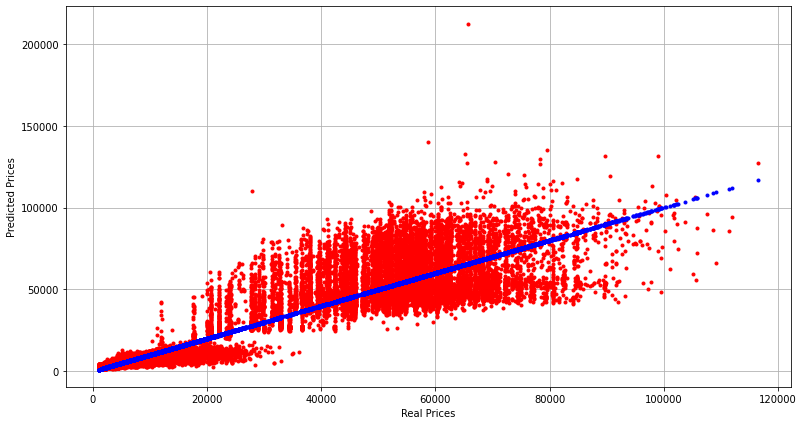

In [655]:
plt.figure(figsize=(13,7))
plt.plot(y_test, y_pred, 'r.', label='Predicted Prices')
plt.plot(y_test, y_test, 'b.', label='Real Prices')
plt.ylabel('Predicted Prices');
plt.xlabel('Real Prices');
plt.grid();

### Finding the 3 most important categorical features and the most important numerical feature

In [656]:
cat_name = model_c[0].transformers_[0][1].get_feature_names_out()
num_name = ['duration', 'days_left']

# List of all features
variables_name = np.concatenate((cat_name,num_name), axis=None)

# Weights/coeficients from the regression
importance = model_c[1].coef_

print(variables_name)
print(importance)

['airline_AirAsia' 'airline_Air_India' 'airline_GO_FIRST' 'airline_Indigo'
 'airline_SpiceJet' 'airline_Vistara' 'source_city_Bangalore'
 'source_city_Chennai' 'source_city_Delhi' 'source_city_Hyderabad'
 'source_city_Kolkata' 'source_city_Mumbai' 'departure_time_Afternoon'
 'departure_time_Early_Morning' 'departure_time_Evening'
 'departure_time_Late_Night' 'departure_time_Morning'
 'departure_time_Night' 'stops_one' 'stops_two_or_more' 'stops_zero'
 'arrival_time_Afternoon' 'arrival_time_Early_Morning'
 'arrival_time_Evening' 'arrival_time_Late_Night' 'arrival_time_Morning'
 'arrival_time_Night' 'destination_city_Bangalore'
 'destination_city_Chennai' 'destination_city_Delhi'
 'destination_city_Hyderabad' 'destination_city_Kolkata'
 'destination_city_Mumbai' 'class_Business' 'class_Economy' 'duration'
 'days_left']
[-1.67139472e+03 -1.58293386e+03 -8.78866702e+00  3.88944464e+02
  4.76270009e+02  2.39790278e+03  3.02736275e+02  2.44314351e+02
 -1.09010507e+03 -1.38597713e+03  1.86158

- features_importance

In [657]:
#Dataframe
features_importance = pd.DataFrame({'Name_coef': variables_name, 'Coefficient Values': importance})

features_importance.head(37)

,Name_coef,Coefficient Values
0,airline_AirAsia,-1671.394721
1,airline_Air_India,-1582.933862
2,airline_GO_FIRST,-8.788667
3,airline_Indigo,388.944464
4,airline_SpiceJet,476.270009
5,airline_Vistara,2397.902777
6,source_city_Bangalore,302.736275
7,source_city_Chennai,244.314351
8,source_city_Delhi,-1090.105071
9,source_city_Hyderabad,-1385.977132


- Airline coefficients Dataframe and the difference between these coefficients

In [658]:
airline_coef = features_importance.iloc[0:6,:]
airline_coef

,Name_coef,Coefficient Values
0,airline_AirAsia,-1671.394721
1,airline_Air_India,-1582.933862
2,airline_GO_FIRST,-8.788667
3,airline_Indigo,388.944464
4,airline_SpiceJet,476.270009
5,airline_Vistara,2397.902777


In [659]:
diff_airline_coef = airline_coef['Coefficient Values'].max() - airline_coef['Coefficient Values'].min()

- Source city coefficients Dataframe and the difference between these coefficients

In [660]:
soure_city_coef = features_importance.iloc[6:12,:]
soure_city_coef

,Name_coef,Coefficient Values
6,source_city_Bangalore,302.736275
7,source_city_Chennai,244.314351
8,source_city_Delhi,-1090.105071
9,source_city_Hyderabad,-1385.977132
10,source_city_Kolkata,1861.587094
11,source_city_Mumbai,67.444483


In [661]:
diff_source_city_coef = soure_city_coef['Coefficient Values'].max() - soure_city_coef['Coefficient Values'].min()

- Departure time coefficients Dataframe and the difference between these coefficients

In [662]:
departure_time_coef = features_importance.iloc[12:18,:]
departure_time_coef

,Name_coef,Coefficient Values
12,departure_time_Afternoon,-813.377817
13,departure_time_Early_Morning,26.186405
14,departure_time_Evening,-74.200437
15,departure_time_Late_Night,944.020042
16,departure_time_Morning,35.649156
17,departure_time_Night,-118.277350


In [663]:
diff_departure_time_coef = departure_time_coef['Coefficient Values'].max() - departure_time_coef['Coefficient Values'].min()

- Stops coefficients Dataframe and the difference between these coefficients

In [664]:
stops_coef = features_importance.iloc[18:21,:]
stops_coef

,Name_coef,Coefficient Values
18,stops_one,1872.719085
19,stops_two_or_more,3937.720375
20,stops_zero,-5810.439460


In [665]:
diff_stops_coef = stops_coef['Coefficient Values'].max() - stops_coef['Coefficient Values'].min()

- Arrival time coefficients Dataframe and the difference between these coefficients

In [666]:
arrival_time_coef = features_importance.iloc[21:27,:]
arrival_time_coef

,Name_coef,Coefficient Values
21,arrival_time_Afternoon,-436.263160
22,arrival_time_Early_Morning,-1248.503060
23,arrival_time_Evening,479.047518
24,arrival_time_Late_Night,451.411735
25,arrival_time_Morning,38.405680
26,arrival_time_Night,715.901287


In [667]:
diff_arrival_time_coef = arrival_time_coef['Coefficient Values'].max() - arrival_time_coef['Coefficient Values'].min()

- Destination city coefficients Dataframe and the difference between these coefficients

In [668]:
destination_city_coef = features_importance.iloc[27:33,:]
destination_city_coef

,Name_coef,Coefficient Values
27,destination_city_Bangalore,364.093801
28,destination_city_Chennai,161.853271
29,destination_city_Delhi,-1197.696678
30,destination_city_Hyderabad,-1384.480785
31,destination_city_Kolkata,1733.892626
32,destination_city_Mumbai,322.337765


In [669]:
diff_destination_city_coef = destination_city_coef['Coefficient Values'].max() - destination_city_coef['Coefficient Values'].min()

- Class coefficients Dataframe and the difference between these coefficients

In [670]:
class_coef = features_importance.iloc[33:35,:]
class_coef

,Name_coef,Coefficient Values
33,class_Business,22480.455307
34,class_Economy,-22480.455308


In [671]:
diff_class_coef = class_coef['Coefficient Values'].max() - class_coef['Coefficient Values'].min()

In [672]:
diff_coefficients = {'diff_airline_coef':diff_airline_coef, 
                     'diff_source_city_coef':diff_source_city_coef,
                     'diff_departure_time_coef': diff_departure_time_coef,
                     'diff_stops_coef': diff_stops_coef,
                     'diff_arrival_time_coef':diff_arrival_time_coef,
                     'diff_destination_city_coef': diff_destination_city_coef,
                     'diff_class_coef': diff_class_coef}

In [673]:
sorted(diff_coefficients.items(), reverse=True, key=operator.itemgetter(1))

[('diff_class_coef', 44960.91061505112),
 ('diff_stops_coef', 9748.15983491535),
 ('diff_airline_coef', 4069.297498804583),
 ('diff_source_city_coef', 3247.5642263027053),
 ('diff_destination_city_coef', 3118.373411839978),
 ('diff_arrival_time_coef', 1964.4043475057401),
 ('diff_departure_time_coef', 1757.3978594116504)]

Sendo assim, vemos que os 3 principais atributos categóricos que possuem maior peso na predição são **class, stops e airline**.

In [674]:
#Para os atributos numéricos
numerical_coef = features_importance.iloc[-2:,:]
numerical_coef

,Name_coef,Coefficient Values
35,duration,41.471715
36,days_left,-130.703393


Numerical feature which have more influence in the prices: **days_left*

## Comentários gerais

- O modelo proposto (model_f3), utilizando regressão polinomial nos valores numéricos, seguido de uma padronização e por último uma regularização apresentou os melhores valores de predição, mesmo que as diferenças fossem sutis ao comparar com modelos sem padronização e regularização (mesmo com as diferenças sutis decidi mantes o modelo com menor taxa de erro)

- Apesar da taxa de erro de aproximadamente 20%, a predição ainda possuiu alguns outliers ao final (observável no gráfico 'Predicted Prices x Real Prices').

- Foi determinado que os atributos categóricos que mais influenciam na previsão são 'class', 'stops' e 'airline' (respectivamente), enquanto o atributo numérico que mais influencia na previsão é 'days_left'.

- Para o trabalho, tem-se que foi bem legal ver o desenvolvimento dao próprio projeto enquanto iamos evoluindo e os modelos/predições iam tornando-se mais precisos e interessantes. 

- Um segundo ponto que gostei bastante também foram os desafios novos, não vistos em aula ou que não constavam nos notebooks de aula, como na 7-c, em que tinhamos que escolher os melhores atributos. Tal ponto, mesmo que mais complicado, fez com que o desenvolvimento fosse maior, visto que demandou mais pesquisa e, consequentemente, maior nível de conhecimento sobre o que estava sendo feito.